In [8]:
import numpy as np
from scipy.spatial import KDTree
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    # Extract coordinates
    coordinates = np.array([(core['x'], core['y']) for core in cores])

    # Normalize coordinates (shift to origin) and invert y-axis
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array(
        [(x - min_x, max_y - y) for x, y in coordinates]
    )

    return normalized_inverted_coordinates

def get_row_col(coord, grid_spacing):
    """
    Extract the row and column from a coordinate.
    :param coord: The coordinate (x, y).
    :param grid_spacing: The grid spacing.
    :return: Tuple of (row, column).
    """
    row = int(round(coord[1] / grid_spacing))
    col = int(round(coord[0] / grid_spacing))
    return row, col

def estimate_grid(normalized_coordinates):
    """
    Estimate the grid pattern based on normalized core coordinates.
    :param normalized_coordinates: Array of normalized core coordinates.
    :return: Estimated row and column deltas.
    """
    # Compute pairwise distances
    kdtree = KDTree(normalized_coordinates)
    # Query the nearest two points for each point
    distances, _ = kdtree.query(normalized_coordinates, k=3)

    # Estimate grid spacing
    # Average distance to the nearest neighbor
    avg_distance = np.median(distances[:, 1])
    return avg_distance


def assign_to_grid(normalized_coordinates, grid_spacing):
    """
    Assign each core to a grid position based on estimated grid spacing, considering
    the inverted y-axis. Also, adjust assignments for neighbor consistency.
    :param normalized_coordinates: Array of normalized core coordinates.
    :param grid_spacing: Estimated grid spacing (average distance between cores).
    :param threshold_distance: Distance threshold for considering neighbors.
    :return: Dictionary of core positions with row and column assignments.
    """
    # Initialize dictionary of core positions with row and column assignments.
    grid_positions = defaultdict(list)

    # First pass: initial assignment
    for idx, coord in enumerate(normalized_coordinates):
        # Get row and column for each core coordinate
        row, col = get_row_col(coord, grid_spacing)
        # Append index of core coordinate to corresponding row and column.
        grid_positions[(row, col)].append(idx)

    return grid_positions

    
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import estimate_transform

def find_control_points(cores):
    # Assuming 'cores' is a list of (x, y) tuples
    # Convert cores to a numpy array for easier manipulation
    core_array = np.array(cores)

    # Top-left core will have the smallest sum of coordinates
    top_left = core_array[np.argmin(np.sum(core_array, axis=1))]
    
    # Top-right core will have the largest x minus y value
    top_right = core_array[np.argmax(core_array[:, 0] - core_array[:, 1])]
    
    # Bottom-left core will have the largest y minus x value
    bottom_left = core_array[np.argmax(core_array[:, 1] - core_array[:, 0])]
    
    # Bottom-right core will have the largest sum of coordinates
    bottom_right = core_array[np.argmax(np.sum(core_array, axis=1))]

    return top_left, top_right, bottom_left, bottom_right



def get_affine_transform(src_coords, dst_coords):
    """
    Estimate the affine transformation matrix from source to destination coordinates.
    :param src_coords: (4, 2)-shaped array of source coordinates.
    :param dst_coords: (4, 2)-shaped array of destination coordinates.
    :return: skimage's AffineTransform object.
    """
    assert src_coords.shape == dst_coords.shape == (4, 2), "There must be four control points."
    
    transform = estimate_transform('affine', src_coords, dst_coords)
    return transform


from sklearn.decomposition import PCA

def straighten_image(normalized_coordinates):
    """
    Straighten the image by aligning the first principal component with the x-axis.
    :param normalized_coordinates: Array of normalized core coordinates.
    :return: Rotated coordinates that align with the x-axis.
    """
    pca = PCA(n_components=2)
    pca.fit(normalized_coordinates)

    # Get the angle to the horizontal axis
    angle = np.arctan2(pca.components_[0][1], pca.components_[0][0])

    # Create a rotation matrix using the negative of the angle
    cos_angle, sin_angle = np.cos(-angle), np.sin(-angle)
    rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

    # Subtract the mean, rotate, and then add the mean back
    rotated_coordinates = np.dot(normalized_coordinates - pca.mean_, rotation_matrix) + pca.mean_

    return rotated_coordinates


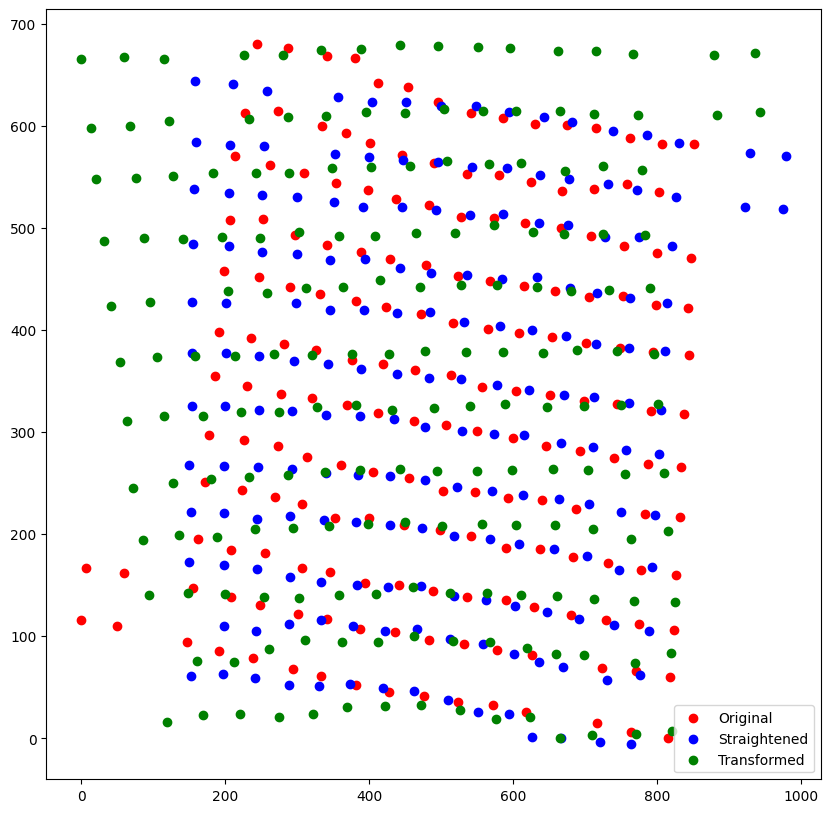

In [9]:
# Main workflow
data = pd.read_json('./TMA_WSI_Labels_updated/ABC_107_1_010_1.json')
data = data.to_dict('records')

# Apply the transformation to all core coordinates
normalized_coordinates = preprocess_cores(data)

# Straighten the image
straightened_coordinates = straighten_image(normalized_coordinates)

# Now, let's find the control points on the straightened coordinates
control_points_straight = find_control_points([(core[0], core[1]) for core in straightened_coordinates])

target_points = np.array([[min(straightened_coordinates[:, 0]), min(straightened_coordinates[:, 1])],
                          [max(straightened_coordinates[:, 0]), min(straightened_coordinates[:, 1])],
                          [min(straightened_coordinates[:, 0]), max(straightened_coordinates[:, 1])],
                          [max(straightened_coordinates[:, 0]), max(straightened_coordinates[:, 1])]])

# Assuming the control points and target points have been correctly identified
affine_transform = get_affine_transform(np.array(control_points_straight), np.array(target_points))

# Apply the transformation to the entire set of straightened coordinates
transformed_coordinates = affine_transform(straightened_coordinates)

# Ensure there aren't any negative coordinates
min_x, min_y = np.min(transformed_coordinates, axis=0)
transformed_coordinates[:, 0] -= min_x
transformed_coordinates[:, 1] -= min_y

# Plotting for verification
plt.figure(figsize=(10, 10))
plt.scatter(normalized_coordinates[:, 0], normalized_coordinates[:, 1], c='r', label='Original')
plt.scatter(straightened_coordinates[:, 0], straightened_coordinates[:, 1], c='b', label='Straightened')
plt.scatter(transformed_coordinates[:, 0], transformed_coordinates[:, 1], c='g', label='Transformed')
plt.legend()
plt.show()

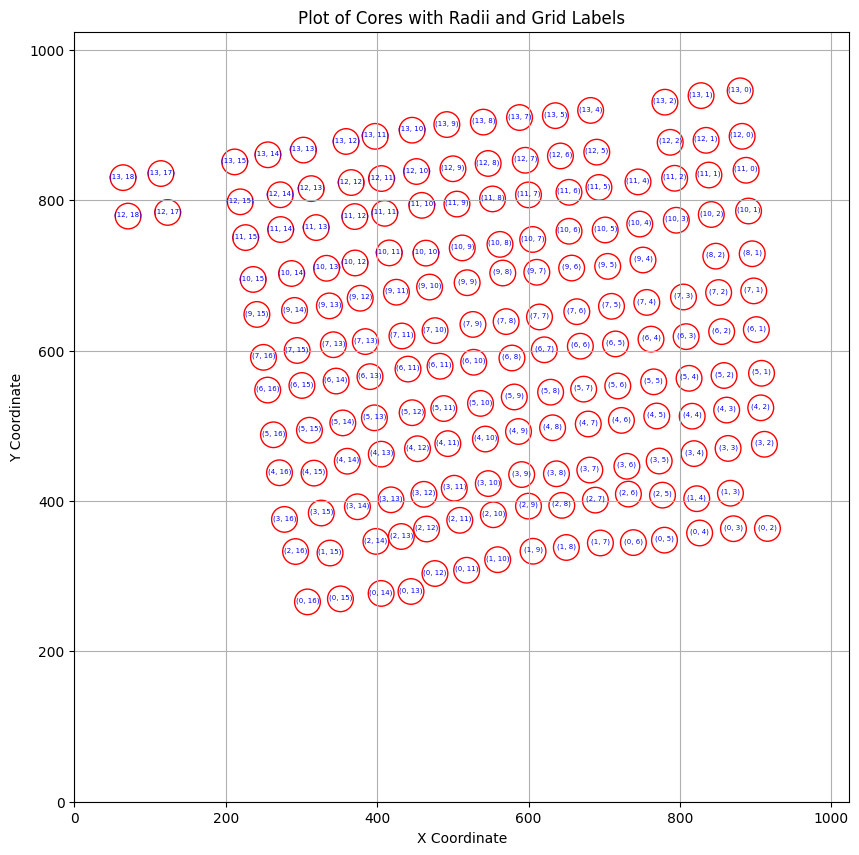

In [16]:
grid_spacing = estimate_grid(transformed_coordinates)

grid_positions = assign_to_grid(transformed_coordinates, grid_spacing)


# Now we will attempt the plotting again, making sure to access the dictionary correctly
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Plot each core with its radius and label
for idx, core in enumerate(data):
    # Draw the core as a circle
    circle = plt.Circle((core['x'], core['y']), radius=core['radius'], edgecolor='r', facecolor='none')
    ax.add_patch(circle)

    # Get grid position for the label
    grid_label = None
    for pos, indices in grid_positions.items():
        if idx in indices:
            grid_label = pos
            break
    
    # Only label the core if we found a grid position
    if grid_label is not None:
        ax.text(core['x'], core['y'], str(grid_label), color='blue', fontsize=5, ha='center')

# Set the limits of the plot to the size of the image
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])

# Add grid, legend, and labels
ax.grid(True)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Plot of Cores with Radii and Grid Labels')

# Show the plot
plt.show()